<a href="https://colab.research.google.com/github/ShamScripts/Retail-Analytics-and-Sales-Forecasting/blob/main/Retail_Analytics_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load Datasets

In [68]:
# Import required libraries
import pandas as pd       # version: 1.5.3
import numpy as np        # version: 1.24.3
import seaborn as sns     # version: 0.12.2
import matplotlib.pyplot as plt  # version: 3.7.1
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Load training dataset
data = pd.read_csv('datasets/train.csv')

In [70]:
# Preview dataset
data.sample(10).style.set_caption("Sample Preview of the Dataset").set_table_attributes('style="width:100%"')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
450,FDE24,14.850000,Low Fat,0.093445,Baking Goods,141.081200,OUT035,2004,Small,Tier 2,Supermarket Type1,1139.849600
2119,FDP44,16.500000,Regular,0.133424,Fruits and Vegetables,102.233200,OUT010,1998,nan,Tier 3,Grocery Store,102.533200
1926,FDC05,13.100000,Regular,0.098766,Frozen Foods,196.376800,OUT035,2004,Small,Tier 2,Supermarket Type1,2167.844800
2528,FDI57,19.850000,Low Fat,0.054026,Seafood,197.276800,OUT046,1997,Small,Tier 1,Supermarket Type1,6503.534400
1618,FDP39,12.650000,Low Fat,0.069566,Meat,52.432400,OUT045,2002,nan,Tier 2,Supermarket Type1,571.256400
6221,FDB23,nan,Regular,0.009785,Starchy Foods,225.906200,OUT019,1985,Small,Tier 1,Grocery Store,451.412400
6855,FDX03,nan,Regular,0.106971,Meat,44.774400,OUT019,1985,Small,Tier 1,Grocery Store,135.823200
3609,FDC14,14.500000,Regular,0.041482,Canned,40.045400,OUT017,2007,nan,Tier 2,Supermarket Type1,209.727000
4156,FDD23,9.500000,Regular,0.048761,Starchy Foods,186.589800,OUT049,1999,Medium,Tier 1,Supermarket Type1,5238.514400
373,FDX09,9.000000,Low Fat,0.065237,Snack Foods,176.437000,OUT035,2004,Small,Tier 2,Supermarket Type1,7763.228000


In [71]:
# Dataset shape
print("Shape of dataset:", data.shape)

Shape of dataset: (8523, 12)


In [72]:
# Summary statistics
data.describe().style.set_caption(" Summary Statistics of Numerical Columns").set_table_attributes("style='width:100%'")

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
# Null value count
print("Null values: ", data.isnull().sum())

Null values:  Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [ ]:
# Null value percentage
missing_percentage = data.isnull().sum() * 100 / len(data)
print(missing_percentage)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


In [ ]:
# Check for duplicates
print("Duplicates: ", data.duplicated().any())

Duplicates:  False


## 2. Explore Datasets in Detail

In [21]:
# Handle missing values in Item_Weight
mean_weight = data['Item_Weight'].mean()
median_weight = data['Item_Weight'].median()
data['Item_Weight_mean'] = data['Item_Weight'].fillna(mean_weight)
data['Item_Weight_median'] = data['Item_Weight'].fillna(median_weight)
data['Item_Weight_interploate'] = data['Item_Weight'].interpolate(method="linear")

In [23]:
# KNN Imputer
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=10, weights="distance")
data['knn_imputer'] = knn.fit_transform(data[['Item_Weight']]).ravel()

In [24]:
# Drop imputation helper columns
data = data.drop(['Item_Weight', 'Item_Weight_mean', 'Item_Weight_median', 'knn_imputer'], axis=1)

In [25]:
# Handle Outlet_Size using mode of Outlet_Type
mode_outlet = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode()[0])
data.loc[data['Outlet_Size'].isnull(), 'Outlet_Size'] = data.loc[data['Outlet_Size'].isnull(), 'Outlet_Type'].apply(lambda x: mode_outlet[x])

In [26]:
# Standardize Fat Content
data.replace({'Item_Fat_Content': {'Low Fat': 'LF', 'low fat': 'LF', 'reg': 'Regular'}}, inplace=True)

In [27]:
# Handle Item_Visibility
data['Item_Visibility_interpolate'] = data['Item_Visibility'].replace(0, np.nan).interpolate(method='linear')
data = data.drop('Item_Visibility', axis=1)

In [28]:
# Simplify Item_Identifier
data['Item_Identifier'] = data['Item_Identifier'].apply(lambda x: x[:2])

In [29]:
# Create Outlet Age
import datetime as dt
current_year = dt.datetime.today().year
data['Outlet_age'] = current_year - data['Outlet_Establishment_Year']
data = data.drop('Outlet_Establishment_Year', axis=1)

In [30]:
# Ordinal Encoding for categorical columns
from sklearn.preprocessing import OrdinalEncoder
data_encoded = data.copy()
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    oe = OrdinalEncoder()
    data_encoded[col] = oe.fit_transform(data_encoded[[col]])

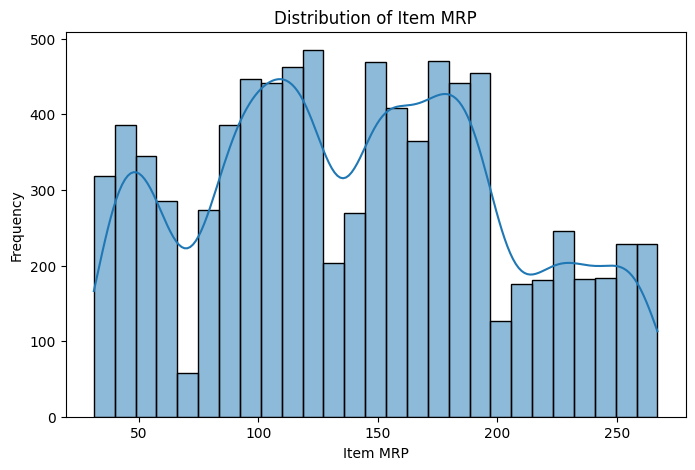

In [31]:
# Distribution of Item MRP
plt.figure(figsize=(8, 5))
sns.histplot(data['Item_MRP'], kde=True)
plt.title('Distribution of Item MRP')
plt.xlabel('Item MRP')
plt.ylabel('Frequency')
plt.show()

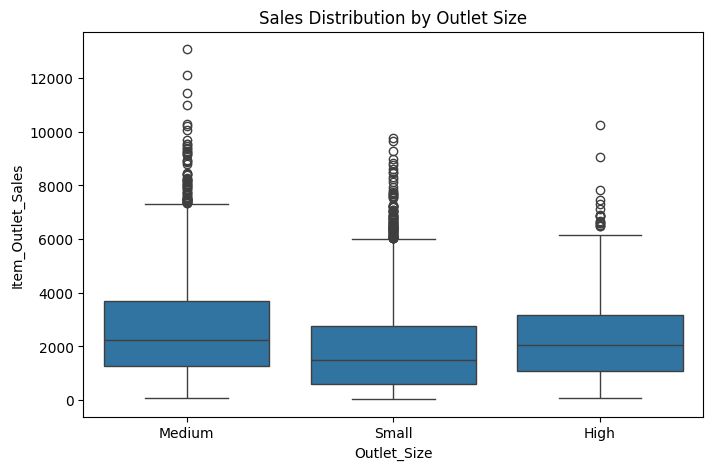

In [32]:
# Boxplot: Sales vs Outlet Size
plt.figure(figsize=(8, 5))
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=data)
plt.title('Sales Distribution by Outlet Size')
plt.show()

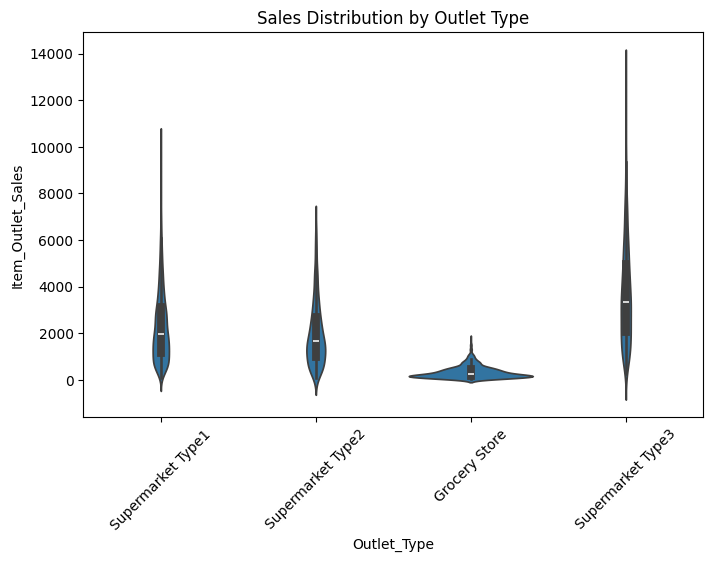

In [33]:
# Violinplot: Sales vs Outlet Type
plt.figure(figsize=(8, 5))
sns.violinplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data)
plt.title('Sales Distribution by Outlet Type')
plt.xticks(rotation=45)
plt.show()

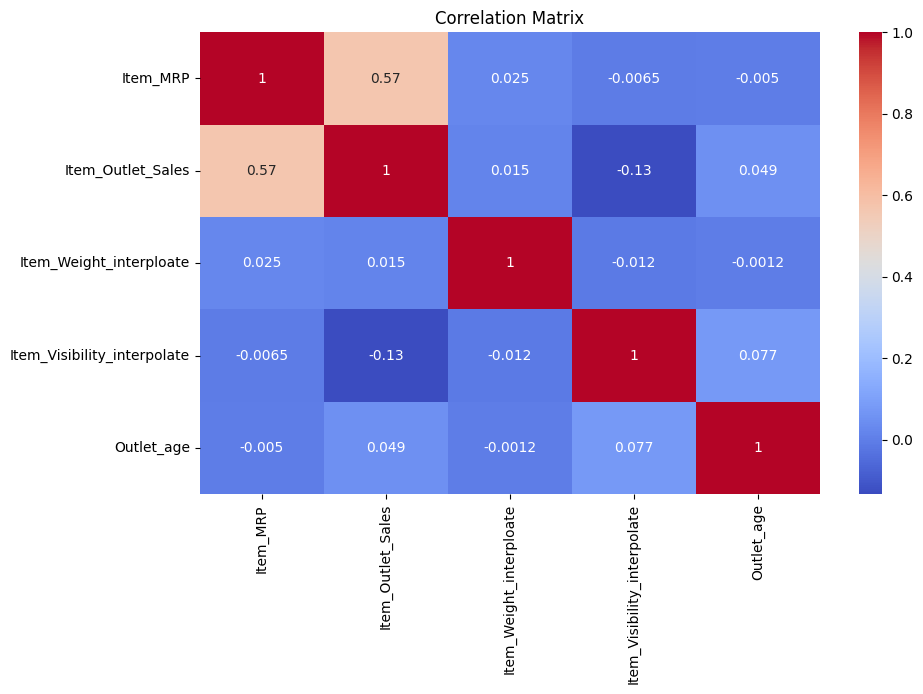

In [34]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
corr = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

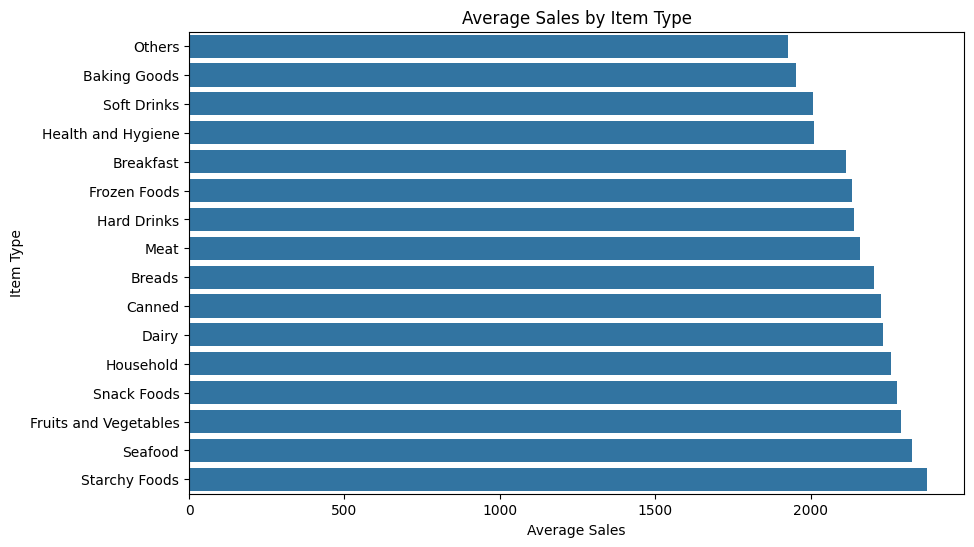

In [35]:
# Barplot: Average Sales by Item Type
item_sales = data.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=item_sales.values, y=item_sales.index)
plt.title('Average Sales by Item Type')
plt.xlabel('Average Sales')
plt.ylabel('Item Type')
plt.show()

## 3. Check for Best ML Model

In [38]:
# Step 3: Model Selection and Comparison
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Define features and target
X = data_encoded.drop('Item_Outlet_Sales', axis=1)
y = data_encoded['Item_Outlet_Sales']

In [40]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBRF Regressor": XGBRFRegressor(n_estimators=100, random_state=42)
}

In [41]:
# Store results
model_scores = {}

In [42]:
# Evaluate each model using 5-fold cross-validation (R² score)
for name, model in models.items():
    score = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
    model_scores[name] = score
    print(f"{name} R2 Score: {score:.4f}")

Linear Regression R2 Score: 0.5015
Ridge Regression R2 Score: 0.5015
Lasso Regression R2 Score: 0.5015
Decision Tree R2 Score: 0.1635
Random Forest R2 Score: 0.5550
XGBRF Regressor R2 Score: 0.5954


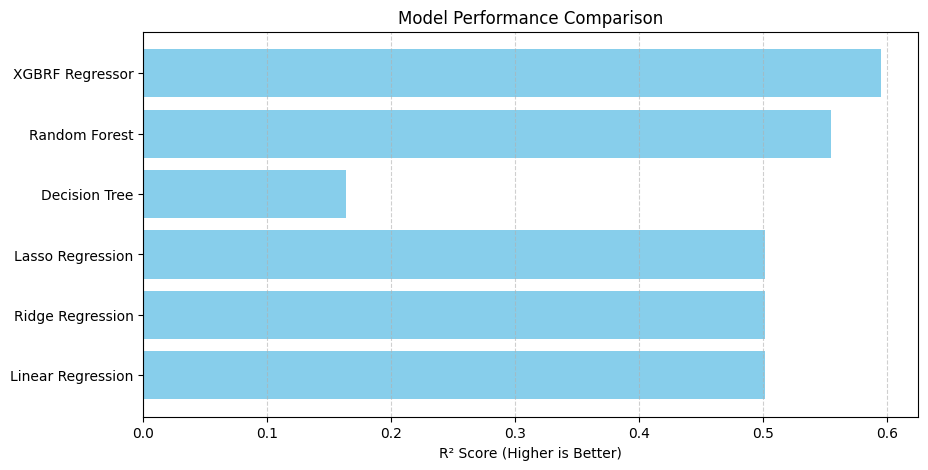

In [43]:
# Bar plot of model R² scores
plt.figure(figsize=(10, 5))
plt.barh(list(model_scores.keys()), list(model_scores.values()), color='skyblue')
plt.xlabel("R² Score (Higher is Better)")
plt.title("Model Performance Comparison")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} MAE: {mae:.2f}")


Linear Regression MAE: 855.57
Ridge Regression MAE: 855.35
Lasso Regression MAE: 855.57
Decision Tree MAE: 1018.42
Random Forest MAE: 758.07
XGBRF Regressor MAE: 714.23


## 4. Train Final Model

In [45]:
# Train XGBRF model to get feature importances
xg1 = XGBRFRegressor(n_estimators=100, random_state=42)
xg1.fit(X, y)

# Manually selected low-importance features based on feature importance analysis
important_cols = ['Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type',
                  'Outlet_Location_Type', 'Item_Identifier', 'Item_Fat_Content']

# Drop less important features for better model performance
X_final = X.drop(columns=important_cols)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Split the optimized dataset
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Final model using XGBRFRegressor
xg_final = XGBRFRegressor(n_estimators=100, random_state=42)
xg_final.fit(X_train, y_train)

# Predict on test set
y_pred = xg_final.predict(X_test)

# Evaluate using MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model MAE: {mae:.2f}")


Final Model MAE: 712.50


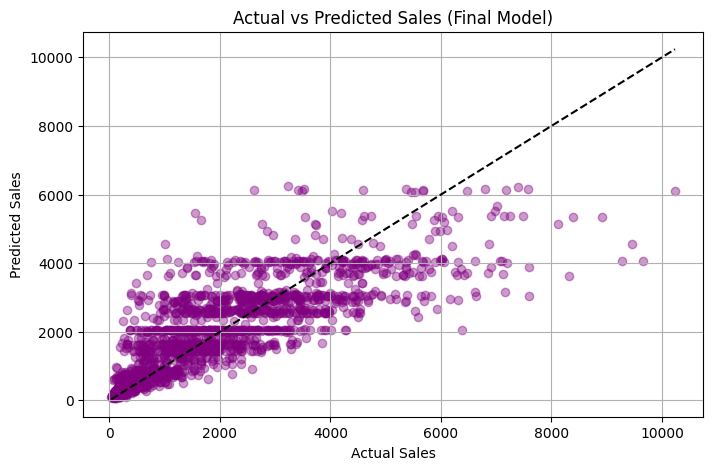

In [47]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.4, color='purple')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Final Model)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.grid(True)
plt.show()


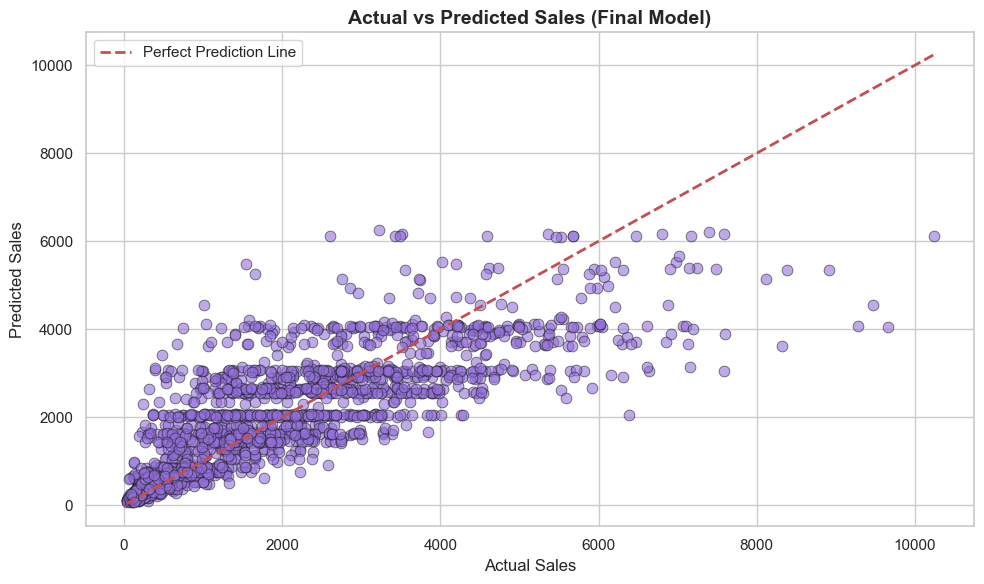

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a better visual layout
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(x=y_test, y=y_pred, color='mediumpurple', alpha=0.6, s=60, edgecolor='k')

# Plot a perfect prediction reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")

# Add labels and title
plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.title("Actual vs Predicted Sales (Final Model)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


## 5. Analyze the Data and Give Result

In [49]:
pred = xg_final.predict(np.array([[141.6180, 9.0, 1.0, 1.0, 24]]))[0]
print(f"Sales Value is between {pred - 714.42:.2f} and {pred + 714.42:.2f}")

Sales Value is between 1336.86 and 2765.70


In [50]:
# Predict for a custom new sample (example values)
sample_input = np.array([[141.6180, 9.0, 1.0, 1.0, 24]])  # sample based on selected features
sample_prediction = xg_final.predict(sample_input)[0]

# Display prediction with a ±714.42 range (based on average std deviation)
print(f"Predicted Sales Value: {sample_prediction:.2f}")
print(f"Sales Value Range: {sample_prediction - 714.42:.2f} to {sample_prediction + 714.42:.2f}")


Predicted Sales Value: 2051.28
Sales Value Range: 1336.86 to 2765.70


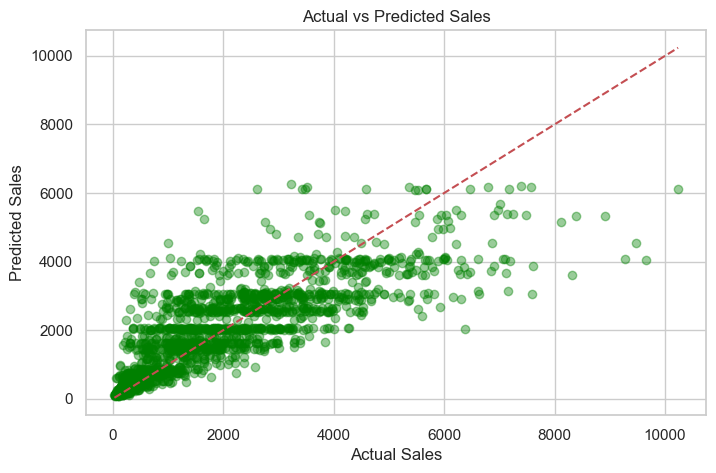

In [51]:
# Scatter plot for actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.4, color='green')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.grid(True)
plt.show()


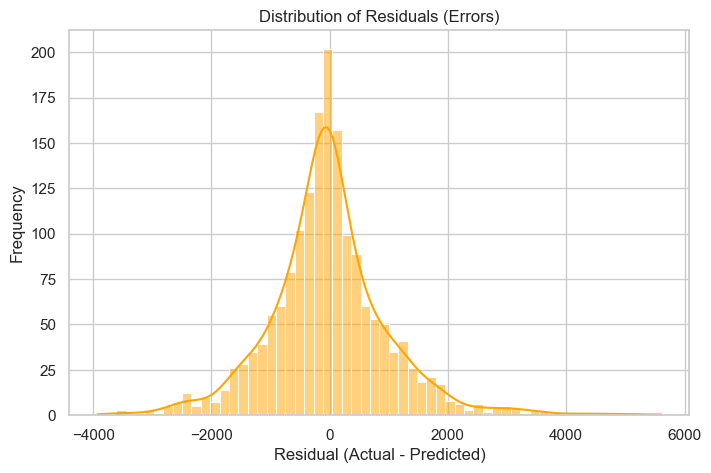

In [52]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='orange')
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## 6. Do Sales Forecasting

In [53]:
import joblib
joblib.dump(xg_final, 'model/bigmart_model.pkl')



['model/bigmart_model.pkl']

In [54]:
# Load model and forecast
model = joblib.load('model/bigmart_model.pkl')
new_pred = model.predict(np.array([[141.6180, 9.0, 1.0, 1.0, 24]]))[0]
print("Forecasted Sales Value:", new_pred)

Forecasted Sales Value: 2051.2847


In [55]:
# Load the test dataset
test_data = pd.read_csv("datasets/test.csv")
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [56]:
# Interpolate Item_Weight
test_data['Item_Weight'] = test_data['Item_Weight'].interpolate(method="linear")

In [57]:
# Handle 0s in Item_Visibility
test_data['Item_Visibility'] = test_data['Item_Visibility'].replace(0, np.nan)
test_data['Item_Visibility_interpolate'] = test_data['Item_Visibility'].interpolate(method='linear')
test_data.drop('Item_Visibility', axis=1, inplace=True)

In [58]:
# Standardize Fat Content
test_data.replace({'Item_Fat_Content': {'Low Fat': 'LF', 'low fat': 'LF', 'reg': 'Regular'}}, inplace=True)

In [59]:
# Simplify Item_Identifier
test_data['Item_Identifier'] = test_data['Item_Identifier'].apply(lambda x: x[:2])

In [60]:
# Create Outlet Age
current_year = 2025
test_data['Outlet_age'] = current_year - test_data['Outlet_Establishment_Year']
test_data.drop('Outlet_Establishment_Year', axis=1, inplace=True)

In [61]:
# Handle missing Outlet_Size
mode_outlet_test = test_data.pivot_table(values='Item_MRP', columns='Outlet_Type', aggfunc='mean')
test_data['Outlet_Size'].fillna("Medium", inplace=True)  # fallback to most frequent

In [62]:
# Ordinal Encode test set like training
from sklearn.preprocessing import OrdinalEncoder
test_encoded = test_data.copy()
for col in test_encoded.select_dtypes(include='object').columns:
    oe = OrdinalEncoder()
    test_encoded[col] = oe.fit_transform(test_encoded[[col]])

In [63]:
# Define the list of columns to drop
important_cols = ['Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type',
                  'Outlet_Location_Type', 'Item_Identifier', 'Item_Fat_Content']

# Drop columns only if they are present
cols_to_drop = [col for col in important_cols if col in test_encoded.columns]
test_final = test_encoded.drop(columns=cols_to_drop)


In [64]:
# Align test features with training features (X_final)
test_final = test_encoded[X_final.columns]

In [65]:
# Predict using trained model
predicted_sales = xg_final.predict(test_final)

In [ ]:
# Add prediction to submission format
# Create submission DataFrame
submission = pd.DataFrame({
    "Item_Identifier": test_data['Item_Identifier'],
    "Outlet_Identifier": test_data['Outlet_Identifier'],
    "Item_Outlet_Sales": predicted_sales
})

In [ ]:
# Save submission file
submission.to_csv("datasets/submission.csv", index=False)
print("Submission file 'submission.csv' generated successfully.")

Submission file 'submission.csv' generated successfully.
